In [1]:
%matplotlib inline


# Cross Session SSVEP


In [2]:
# Authors: Sylvain Chevallier <sylvain.chevallier@uvsq.fr>
#
# License: BSD (3-clause)

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from classifiers import MDM
#from classifiers import TangentSpace
from pyriemann.estimation import Covariances
#from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

#from estimation import Covariances
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

import moabb
from moabb.datasets import MAMEM3, SSVEPExo
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import SSVEP,FilterBankSSVEP
from moabb.pipelines import ExtendedSSVEPSignal


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

## Loading dataset




In [3]:
dataset = SSVEPExo()
#dataset.subject_list=dataset.subject_list[11:]
print(dataset.subject_list)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [4]:
dataset.interval

[2, 4]

In [5]:
records = dataset.get_data()
records

{1: {'session_0': {'run_0': <Raw | subject01_run1_raw.fif, 9 x 57024 (222.7 s), ~3.9 MB, data loaded>,
   'run_1': <Raw | subject01_run2_raw.fif, 9 x 78144 (305.2 s), ~5.4 MB, data loaded>}},
 2: {'session_0': {'run_0': <Raw | subject02_run1_raw.fif, 9 x 71712 (280.1 s), ~4.9 MB, data loaded>,
   'run_1': <Raw | subject02_run2_raw.fif, 9 x 59456 (232.2 s), ~4.1 MB, data loaded>}},
 3: {'session_0': {'run_0': <Raw | subject03_run1_raw.fif, 9 x 63040 (246.2 s), ~4.3 MB, data loaded>,
   'run_1': <Raw | subject03_run2_raw.fif, 9 x 59040 (230.6 s), ~4.1 MB, data loaded>}},
 4: {'session_0': {'run_0': <Raw | subject04_run1_raw.fif, 9 x 63648 (248.6 s), ~4.4 MB, data loaded>,
   'run_1': <Raw | subject04_run2_raw.fif, 9 x 57120 (223.1 s), ~3.9 MB, data loaded>}},
 5: {'session_0': {'run_0': <Raw | subject05_run1_raw.fif, 9 x 58848 (229.9 s), ~4.1 MB, data loaded>,
   'run_1': <Raw | subject05_run2_raw.fif, 9 x 68576 (267.9 s), ~4.7 MB, data loaded>}},
 6: {'session_0': {'run_0': <Raw | subje

## Choose paradigm



In [6]:
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=4)

2021-07-02 09:16:18,374 WARNING MainThread moabb.paradigms.ssvep Choosing the first 4 classes from all possible events


In [7]:
freqs = paradigm_fb.used_events(dataset)
print(freqs)

{'13': 2, '17': 3, '21': 4, 'rest': 1}


In [8]:
X, y, metadata = paradigm_fb.get_data(dataset)

In [9]:
dictio={"rest":0,"13":1,"21":2,"17":3}
y_= [dictio[y[l]] for l in range(len(y))]
y =np.asarray(y_)

In [10]:
print(X.shape)
print(y.shape)

(960, 8, 513, 3)
(960,)


In [11]:
signals = []
labels=[]
n_sessions=[]
n = 0
for subject in dataset.subject_list :
    n_session = len(records[subject]['session_0'])
    n_sessions.append(n_session)
    m = n+32*n_session
    signals.append(X[n:m])
    labels.append(y[n:m])
    n= m 

In [12]:
print(len(signals)==len(labels))

True


## Create pipelines

Use a Canonical Correlation Analysis classifier



In [14]:
pipeline = {}
pipeline["MDM"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(),
    MDM()
)

pipeline["TS+LogReg"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(),
    TangentSpace(),
    LogisticRegression()
)

## Evaluation

The evaluation will return a dataframe containing a single AUC score for
each subject / session of the dataset, and for each pipeline.



In [13]:
def split(signal,n_session):
    trains_idx,tests_idx = [],[]
    for i in range(n_session):
        test_idx = list(range(i*32,(i+1)*32))
        train_idx=[]
        for j in range(signal.shape[0]):
            if not (j in test_idx):
                train_idx.append(j)
        trains_idx.append(train_idx)
        tests_idx.append(test_idx)
    return trains_idx,tests_idx


In [15]:
results = {"subject":[],"score":[],"train samples":[], "test samples":[], "pipeline":[]}
for k in pipeline.keys():
    clf= pipeline[k]
    print(k)
    for i in range(len(dataset.subject_list)):
        subject = dataset.subject_list[i]
        accs= []
        signal,n_session,label = signals[i],n_sessions[i],labels[i]
        trains_idx,tests_idx = split(signal,n_session)
        for train_idx,test_idx in zip(trains_idx,tests_idx):
            X_train,X_test = signal[train_idx],signal[test_idx]
            y_train,y_test = label[train_idx],label[test_idx]
            clf.fit(X_train,y_train)
            preds= clf.predict(X_test)
            acc = np.mean(preds==y_test)
            accs.append(acc)
        results["subject"].append(subject)
        results["score"].append(np.mean(accs))
        results["pipeline"].append(k)
        results["train samples"].append(len(train_idx))
        results["test samples"].append(len(test_idx))
      

MDM
TS+LogReg


## Plot Results

Here we plot the results, indicating the score for each session and subject



In [16]:
import pandas as pd
df = pd.DataFrame(results)
df

,subject,score,train samples,test samples,pipeline
0,1,0.437500,32,32,MDM
1,2,0.578125,32,32,MDM
2,3,0.843750,32,32,MDM
3,4,0.625000,32,32,MDM
4,5,0.484375,32,32,MDM
5,6,0.609375,32,32,MDM
6,7,0.645833,64,32,MDM
7,8,0.640625,32,32,MDM
8,9,0.375000,32,32,MDM
9,10,0.468750,96,32,MDM


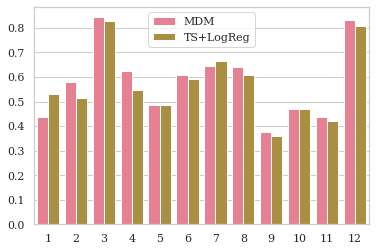

In [17]:
plt.figure()
sns.barplot(data=results, y="score", x="subject", hue="pipeline")

plt.show()